In [1]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName('Structured APIs').getOrCreate()

25/10/01 09:15:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [8]:
spark

The
Structured APIs are a tool for manipulating all sorts of data, from
unstructured log files to semi-structured CSV files and highly structured
Parquet files. These APIs refer to three core types of distributed collection
APIs:
Datasets
DataFrames
SQL tables and views
Although they are distinct parts of the book, the majority of the Structured
APIs apply to both batch and streaming computation. This means that
when you work with the Structured APIs, it should be simple to migrate
from batch to streaming (or vice versa) with little to no effort

DataFrames and Datasets

DataFrames and Datasets are (distributed) table-like collections with well-
defined rows and columns. Each column must have the same number of
rows as all the other columns (although you can use null to specify the
absence of a value) and each column has type information that must be
consistent for every row in the collection.

Schemas

A schema defines the column names and types of a DataFrame. You can
define schemas manually or read a schema from a data source (often
called schema on read).

Spark is effectively a programming language of its own. Internally, Spark
uses an engine called Catalyst that maintains its own type information
through the planning and processing of work. In doing so, this opens up a
wide variety of execution optimizations that make significant differences.
Spark types map directly to the different language APIs that Spark
maintains and there exists a lookup table for each of these in Scala, Java,
Python, SQL, and R. Even if we use Spark’s Structured APIs from Python
or R, the majority of our manipulations will operate strictly on Spark
types, not Python types

for example

df = spark.range(500).toDF("number")
df.select(df["number"] + 10)

Datasets vs Dataframes

Datasets check the type at compile time whereas Dataframes checks at runtime, Datasets available only to jvm language

DataFrames are simply Datasets of Type Row. The “Row” type is
Spark’s internal representation of its optimized in-memory format for
computation.

This format makes for highly specialized and efficient
computation because rather than using JVM types, which can cause high
garbage-collection and object instantiation costs, Spark can operate on its
own internal format without incurring any of those costs. To Spark (in
Python or R), there is no such thing as a Dataset: everything is aDataFrame and therefore we always operate on that optimized format.

Overview of Structured API Execution

1. Write DataFrame/Dataset/SQL Code.
2. If valid code, Spark converts this to a Logical Plan.
3. Spark transforms this Logical Plan to a Physical Plan, checking for
optimizations along the way.
4. Spark then executes this Physical Plan (RDD manipulations) on the
cluster.

This code then passes
through the Catalyst Optimizer, which decides how the code should be
executed and lays out a plan for doing so before, finally, the code is run
and the result is returned to the user.

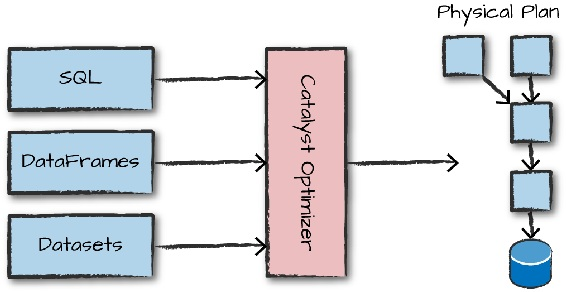

Logical Planning

* take user code and convert it into a logical plan.

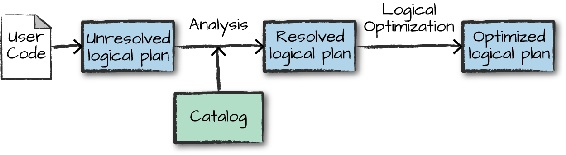

it’s purely to convert the user’s set of
expressions into the most optimized version. It does this by converting
user code into an unresolved logical plan. This plan is unresolved because
although your code might be valid, the tables or columns that it refers to
might or might not exist. Spark uses the catalog, a repository of all table
and DataFrame information, to resolve columns and tables in the analyzer.
The analyzer might reject the unresolved logical plan if the required table
or column name does not exist in the catalog. If the analyzer can resolve it,
the result is passed through the Catalyst Optimizer, a collection of rules
that attempt to optimize the logical plan by pushing down predicates or
selections. Packages can extend the Catalyst to include their own rules for
domain-specific optimizations.

Physical Planning

After successfully creating an optimized logical plan, Spark then beginsthe physical planning process. The physical plan, often called a Spark
plan, specifies how the logical plan will execute on the cluster by
generating different physical execution strategies and comparing them
through a cost model, as depicted in Figure 4-3. An example of the cost
comparison might be choosing how to perform a given join by looking at
the physical attributes of a given table (how big the table is or how big its
partitions are).

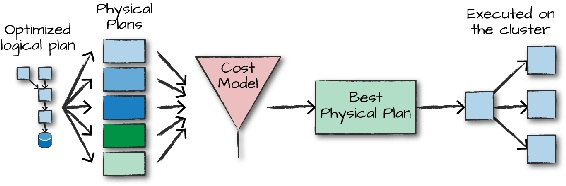

Physical planning results in a series of RDDs and transformations. This
result is why you might have heard Spark referred to as a compiler—it
takes queries in DataFrames, Datasets, and SQL and compiles them into
RDD transformations for you.

Upon selecting a physical plan, Spark runs all of this code over RDDs, the
lower-level programming interface of Spark (which we cover in Part III).
Spark performs further optimizations at runtime, generating native Java
bytecode that can remove entire tasks or stages during execution. Finally
the result is returned to the user.